[Course](http://deeppavlov.ai/rl_course_2020) project #6.

# Problem description

Reinforcement learning can acquire complex behaviors. When talking about reinforcement learning problem statement, it is supposed we have an environment and some agent. They communicate through actions, states and reward. States and actions are usually quite simple, and given specific agent in specific environment there's not much we can do about state or action space. As for reward, it can be defined by us. Reward design is crucial for solving the problem, but it is difficult to find some function that can  be  optimized effectively and encodes the correct task

![circle](./imgs/circle.png)

So, if we learn policy, why don't learn the reward, too?

The main idea of the [paper](https://arxiv.org/pdf/1603.00448.pdf) is to have a reward (cost function in authors terms) being defined with a neural network. Cost function and policy are learned simultaneously.

# Main Idea 

This method is called 'guided costlearning' because the  policy  optimization  “guides”  the  cost  toward good regions of the space.

"We use rich, expressive function approximators, in the form  of  neural  networks,  to  learn  cost  functions  directly on  raw  state  representations. "

Since I don't have any expert trajectories for my environments, for demo trajectories I'll use some other good algorithm result.

# Environmemt

At first we should make sure that our algorithm works on something simple and then to look at more complex environments. (Spoiler: for now it doesn't)

1. For trial runs we use CartPole: 
    4 floats as state, 2 discrete actions

2. To go deeper - Atari environments, which we later can compare to benchmarks from [here](http://htmlpreview.github.io/?https://github.com/openai/baselines/blob/master/benchmarks_atari10M.htm)

(action and states spaces, reward function) specific aspects of env if present

# Imports

In [1]:
import gym
from gym import envs
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output

import gcl

%matplotlib inline

# toy env cartpole 

## General settings

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
env_name = 'CartPole-v1'
env = gcl.make_env_cartpole(env_name, seed)
state = env.reset()

n_actions = env.action_space.n
state_shape = env.observation_space.shape

/home/alina/conda/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## getting demo trajectories

In [6]:
model = gcl.AgentVPG(state_shape, n_actions, 'toy')

In [7]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.9)

mean reward:733.160


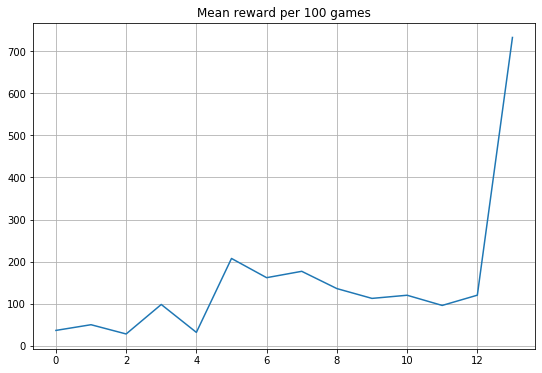

In [8]:
mean_rewards = []
for i in range(100):
    rewards = [gcl.train_vpg_on_session(model, env, *model.generate_session(env), optimizer)
               for _ in range(100)] 
    mean_rewards.append(np.mean(rewards))
    if i % 5:
        clear_output(True)
        print("mean reward:%.3f" % (np.mean(rewards)))
        plt.figure(figsize=[9, 6])
        plt.title("Mean reward per 100 games")
        plt.plot(mean_rewards)
        plt.grid()
        plt.show()
    
    if np.mean(rewards) > 500:
        break

In [9]:
torch.save(model.state_dict(), 'model_vpg.pt')
#model.load_state_dict('model_vpg.pt')

In [10]:
num_demo = 500

In [11]:
demo_samples = [model.generate_session(env) for i in range(num_demo)]

## GCL training

We take cost function architecture from the paper (section 6.1). For the cartpole it might be overkill. Let's see.

We're supposed to have regularization on weights and some not straightforward thing to calculate the cost. We'll make the framework so that it could be expanded in the future, but for now we won't be doing this equation (2)

In [12]:
new_model = gcl.AgentVPG(state_shape, n_actions, 'toy')
cost = gcl.CostNN(state_shape)
optimizer_model = torch.optim.Adam(new_model.parameters(), 1e-3)
optimizer_cost = torch.optim.Adam(cost.parameters(), 1e-3)

mean reward:9.000


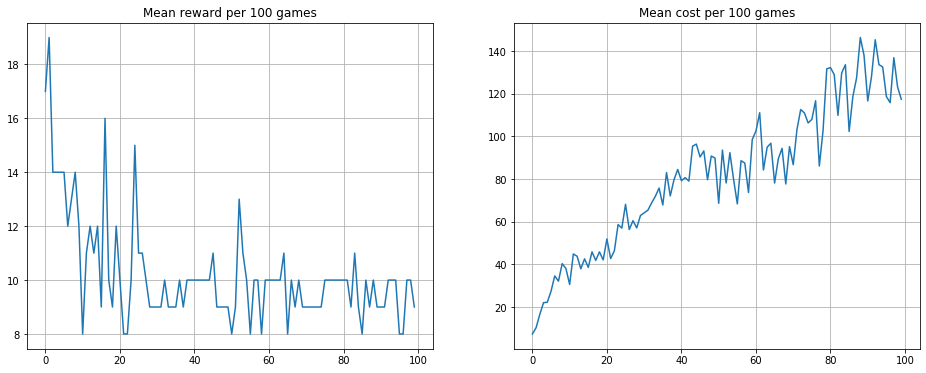

In [13]:
mean_rewards = []
mean_costs = []
size = 100
samples = [new_model.generate_session(env) for _ in range(int(size/2))]
for i in range(100):
    traj = [new_model.generate_session(env) for _ in range(int(size))]
    samples = samples + traj
    #generate samples
    demo_trajs_ids = np.random.choice(range(len(demo_samples)), size)
    demo_trajs = np.array(demo_samples)[demo_trajs_ids]
    #sampled_trajs_ids = np.random.choice(range(len(samples)), size)
    sampled_trajs = traj#np.array(samples)[sampled_trajs_ids]
    rewards, costs = [],  []
    for (demo_traj, sampled_traj) in zip(demo_trajs, sampled_trajs):
        rew, cost_item = gcl.train_gcl_on_session(
                        new_model,
                        env,
                        cost, 
                        demo_traj,
                        sampled_traj,
                        optimizer_model, 
                        optimizer_cost,
                    )
    
    rewards.append(rew)
    costs.append(cost_item)
    mean_rewards.append(np.mean(rewards))
    mean_costs.append(np.mean(costs))
    
    if i % 5:
        clear_output(True)
        print("mean reward:%.3f" % (np.mean(rewards)))
        
        plt.figure(figsize=[16, 6])
        plt.subplot(1, 2, 1)

        plt.title(f"Mean reward per {size} games")
        plt.plot(mean_rewards)
        plt.grid()

        
        plt.subplot(1, 2, 2)
        plt.title(f"Mean cost per {size} games")
        plt.plot(mean_costs)
        plt.grid()
        
        plt.show()

    
    if np.mean(rewards) > 500:
        break

# Training on Atari 

Unfortunately, my too basic knowledge of RL made it impossible to run it on Atari envs in time, despite all my attempts.  